In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
k_map = 100
peak_size = 500

In [4]:
outfile_score = '../outs/human_non_peak_regions_mappability_scores_k{}_{}bp.txt'
outfile_counts = '../outs/human_non_peak_regions_counts_{}bp.bed'
blacklist = '../hg38/human_1kb_bins_less_zero_and_quant_.02_extend_1kb_merge_5kb_with_encode_blacklist.bed'
blacklist_overlaps = '../outs/{}bp_blacklist_overlaps.bed'
bedtools  = '/projects/ps-renlab2/earmand/conda_envs/bedtools/bin/bedtools'

In [5]:
out_score = outfile_score.format(k_map, peak_size)
out_counts = outfile_counts.format(peak_size)
blacklist_overlap = blacklist_overlaps.format(peak_size)
out_score_peaks = f'../outs/human_peak_regions_mappability_scores_{peak_size}bp.txt'
out_counts_peaks = f'../outs/human_peak_regions_counts_{peak_size}bp.bed'

In [6]:
!{bedtools} intersect -a {blacklist} -b {out_counts} -wb -f .1 > $blacklist_overlap

In [7]:
# remove very low mapping regions
min_map = .1 #0.5
max_map = 1 #.85

In [8]:
map_score_peaks = pd.read_csv(out_score_peaks, sep='\t', header=None).set_index(0)
map_score = pd.read_csv(out_score, sep='\t', header=None).set_index(0)

In [9]:
map_score_peaks = map_score_peaks.loc[(map_score_peaks[4] >= min_map) & (map_score_peaks[4] <= max_map)] 
map_score = map_score.loc[(map_score[4] >= min_map) & (map_score[4] <= max_map)] 

In [10]:
blacklist = pd.read_csv(blacklist_overlap, sep='\t', header=None)

In [11]:
counts_peaks = pd.read_csv(out_counts_peaks, sep='\t', header=None).set_index(3)
counts = pd.read_csv(out_counts, sep='\t', header=None).set_index(3)

### remove blacklist regions from random regions
(peaks already filtered)

In [12]:
counts= counts.loc[counts.index.isin(map_score.index.values)]
counts = counts.loc[~counts.index.isin(blacklist[6].unique())]

map_score = map_score.reindex(counts.index)
map_score_peaks = map_score_peaks.reindex(counts_peaks.index)

In [13]:
from scipy.stats import spearmanr, pearsonr

In [14]:
counts['logcpm'] = counts[4] *1e6 /counts[4].sum()
counts['logcpm'] = np.log2(counts['logcpm'] + 1)

In [15]:
counts_peaks['logcpm'] = counts_peaks[4] *1e6 /counts_peaks[4].sum()
counts_peaks['logcpm'] = np.log2(counts_peaks['logcpm'] + 1)

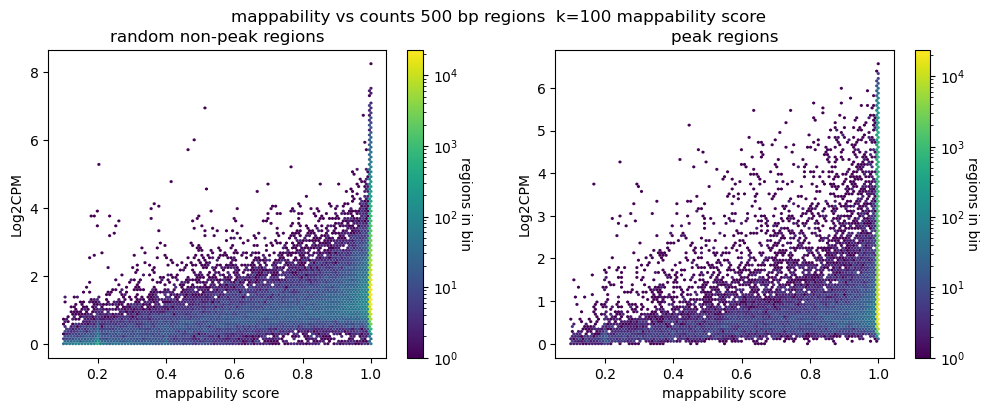

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flatten()
ax = axs[0]
im = ax.hexbin(map_score[4], counts['logcpm'],
               bins='log',linewidth=0,
               # marginals=True
              )
ax.set_xlabel('mappability score')
ax.set_ylabel('Log2CPM')
ax.set_title('random non-peak regions')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('regions in bin',
                       rotation=270,
                       labelpad=10)
ax = axs[1]
im = ax.hexbin(map_score_peaks[4], counts_peaks['logcpm'],
               bins='log',linewidth=0,
               # marginals=True
              )
ax.set_xlabel('mappability score')
ax.set_ylabel('Log2CPM')
ax.set_title('peak regions')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('regions in bin',
                       rotation=270,
                       labelpad=10)
fig.suptitle(f'mappability vs counts {peak_size} bp regions  k={k_map} mappability score')
plt.savefig('../figures/hexbin_map_500bp.pdf',
                transparent=True,
            bbox_inches='tight',
                dpi=400)

In [17]:
def boxplot_interval(group_values, 
                     plot_values, 
                     bins=np.linspace(0, 1, 11),
                    title=None,
                    ax=None):
    df = pd.DataFrame({
    'First': group_values,
    'Second': plot_values
    })
    
    df['mappability'] = pd.cut(df['First'], 
                               bins=bins,
                               include_lowest=False)
    # plt.figure(figsize=(12,6))
    df.boxplot(column='Second', by='mappability',
               showfliers=False,
               grid=False, ax=ax)
    if ax:
        ax.set_xticks(np.arange(10)+1, [f"{i/10}-{(i+1)/10}" for i in range(10)])    
        ax.set_ylabel('log2 cpm')
        ax.set_xlabel('mappability range')
        if title:
            ax.set_title(title)
        else:
            ax.set_title(f'{peak_size} bp non-peaks k={k_map} mappability score')
        
    else: 
        plt.xticks(np.arange(10)+1, [f"{i/10}-{(i+1)/10}" for i in range(10)])    
        plt.ylabel('log2 cpm')
        plt.xlabel('mappability range')

        if title:
            plt.title(title)
        else:
            plt.title(f'{peak_size} bp non-peaks k={k_map} mappability score')


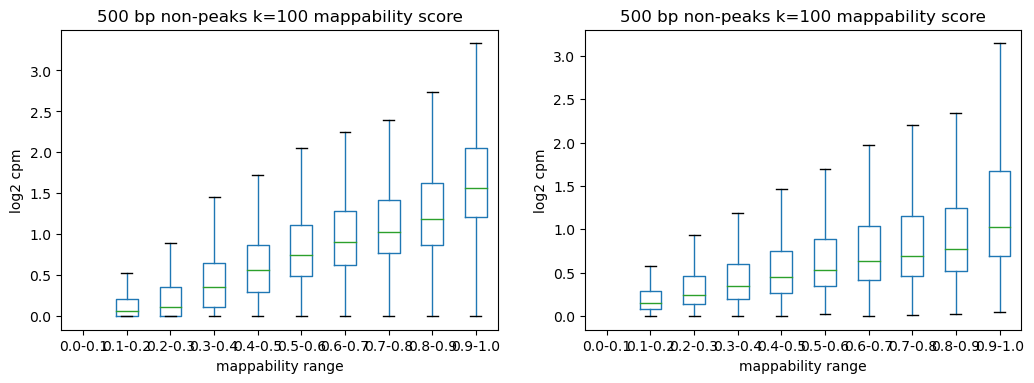

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flatten()
boxplot_interval(map_score[4], counts['logcpm'], ax=axs[0])
boxplot_interval(map_score_peaks[4], counts_peaks['logcpm'], ax=axs[1])
fig.suptitle('')

plt.savefig('../figures/boxplot_500bp.pdf',
                transparent=True,
            bbox_inches='tight',
                dpi=400)

In [19]:
spearmanr(counts_peaks['logcpm'], map_score_peaks[4], nan_policy='omit')

SignificanceResult(statistic=0.10684831650649226, pvalue=0.0)

In [20]:
spearmanr(counts['logcpm'], map_score[4], nan_policy='omit')

SignificanceResult(statistic=0.23949285722619035, pvalue=0.0)

In [21]:
counts['map_normed_counts'] = counts[4]/map_score[4]
counts['map_normed_logcpm'] = np.log2((1e6 * counts.map_normed_counts)/counts.map_normed_counts.sum() +1)

In [22]:
counts['map_normed_logcpm'] = np.log2(counts['cpm']/map_score[4]+1)

KeyError: 'cpm'

In [ ]:
counts_peaks['map_normed_counts'] = counts_peaks[4]/map_score_peaks[4]

counts_peaks['map_normed_logcpm'] = np.log2((1e6 * counts_peaks.map_normed_counts)/counts_peaks.map_normed_counts.sum() +1)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flatten()
ax = axs[0]
im = ax.hexbin(map_score[4], counts['map_normed_logcpm'],
               bins='log',linewidth=0,
               # marginals=True
              )
ax.set_xlabel('mappability score')
ax.set_ylabel('log2 mappability normalized CPM')
ax.set_title('random non-peak regions')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('regions in bin',
                       rotation=270,
                       labelpad=10)
ax = axs[1]
im = ax.hexbin(map_score_peaks[4], counts_peaks['map_normed_logcpm'],
               bins='log',linewidth=0,
               # marginals=True
              )
ax.set_xlabel('mappability score')
ax.set_ylabel('Log2 mappability normalized CPM')
ax.set_title('peak regions')
cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('regions in bin',
                       rotation=270,
                       labelpad=10)
fig.suptitle(f'mappability vs noramlized counts {peak_size} bp regions  k={k_map} mappability score')
# plt.savefig('../figures/hexbin_map_500bp.pdf',
#                 transparent=True,
#             bbox_inches='tight',
#                 dpi=400)

In [ ]:
def boxplot_interval(group_values, 
                     plot_values, 
                     bins=np.linspace(0, 1, 11),
                    title=None,
                    ax=None):
    df = pd.DataFrame({
    'First': group_values,
    'Second': plot_values
    })
    
    df['mappability'] = pd.cut(df['First'], 
                               bins=bins,
                               include_lowest=False)
    # plt.figure(figsize=(12,6))
    df.boxplot(column='Second', by='mappability',
               showfliers=False,
               grid=False, ax=ax)
    if ax:
        ax.set_xticks(np.arange(10)+1, [f"{i/10}-{(i+1)/10}" for i in range(10)])    
        ax.set_ylabel('log2 cpm')
        ax.set_xlabel('mappability range')
        if title:
            ax.set_title(title)
        else:
            ax.set_title(f'{peak_size} bp non-peaks k={k_map} mappability score')
        
    else: 
        plt.xticks(np.arange(10)+1, [f"{i/10}-{(i+1)/10}" for i in range(10)])    
        plt.ylabel('log2 cpm')
        plt.xlabel('mappability range')

        if title:
            plt.title(title)
        else:
            plt.title(f'{peak_size} bp non-peaks k={k_map} mappability score')


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
axs = axs.flatten()
boxplot_interval(map_score[4], counts['map_normed_logcpm'], ax=axs[0])
boxplot_interval(map_score_peaks[4], counts_peaks['map_normed_logcpm'], ax=axs[1])
fig.suptitle('')

plt.savefig('../figures/boxplot_500bp.pdf',
                transparent=True,
            bbox_inches='tight',
                dpi=400)

In [ ]:
spearmanr(map_score[4], counts['map_normed_logcpm'])

In [ ]:
spearmanr(map_score_peaks[4], counts_peaks['map_normed_logcpm'], nan_policy='omit')